In [55]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage.morphology
import skimage.measure
import skimage.segmentation
import sklearn.preprocessing
import imageio
import glob
import cv2
from scipy.spatial import distance as dist
import pyefd
import math

Images/depth/usable\2.tiff


(-0.5, 1279.5, 719.5, -0.5)

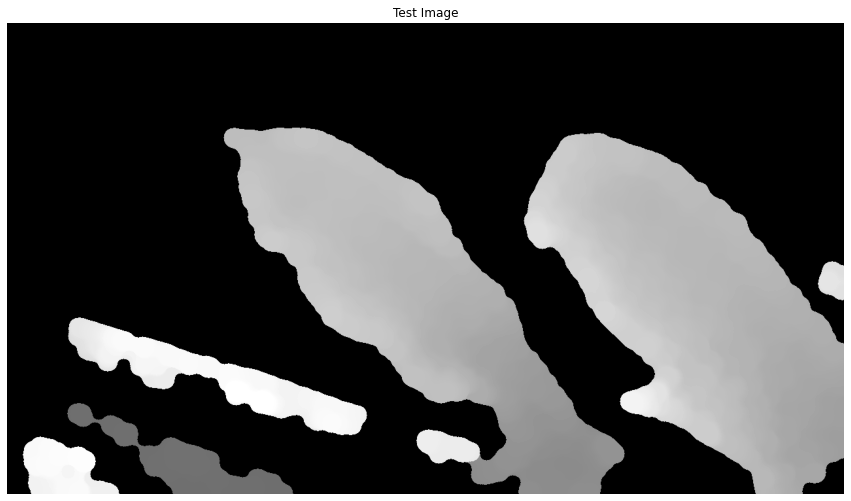

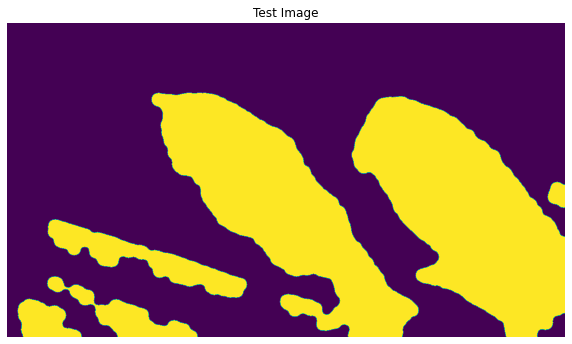

In [56]:
#inputs---------------------------------

img_num = 2
img_names = glob.glob('Images/depth/usable/*')
img = imageio.imread(img_names[img_num])

print(img_names[img_num])

if np.shape(np.shape(img))[0] == 3:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# scale_file = open("Images/depth_scale.txt", "r")
# depth_scale = float(scale_file.readlines()[0][0:5])

#functions-----------------------------
max_dist = np.max(img)
min_dist = np.min(img)
#img_post = np.where((img>min_dist-100) & (img<max_dist-400), img, 0)

otsu_thresh = skimage.filters.threshold_otsu(img)
img_post = np.where(img< otsu_thresh, img, 0)
img_post = skimage.morphology.remove_small_objects(img_post, 64)
img_post = skimage.morphology.opening(img_post, skimage.morphology.disk(15))
img_post = skimage.morphology.closing(img_post, skimage.morphology.disk(10))
# otsu_thresh = skimage.filters.threshold_otsu(img_post)
# print(otsu_thresh)
# img_post = np.where(img_post< otsu_thresh, img_post, 0)




img_mask = np.where(img_post != 0, 1, 0)

plt.figure(figsize=(15,15))
plt.imshow(img_post, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.figure(figsize=(10,10))
plt.imshow(img_mask)
plt.title("Test Image")
plt.axis('off')

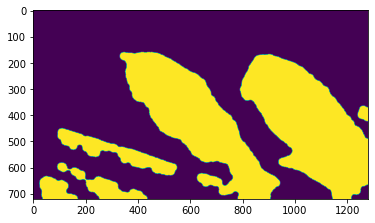

In [57]:
plt.imshow(img_mask)

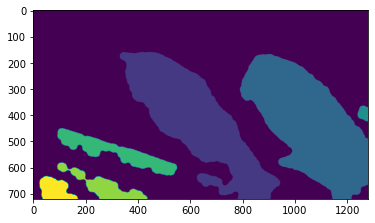

In [58]:
#Segmentation for FD

img_seg = skimage.measure.label(img_mask, background = 0, connectivity=2)
#img_seg = skimage.measure.label(skimage.segmentation.slic(img_post, n_segments = 10,  compactness=0.01, sigma = 5))
plt.imshow(img_seg)

148959


(-0.5, 1279.5, 719.5, -0.5)

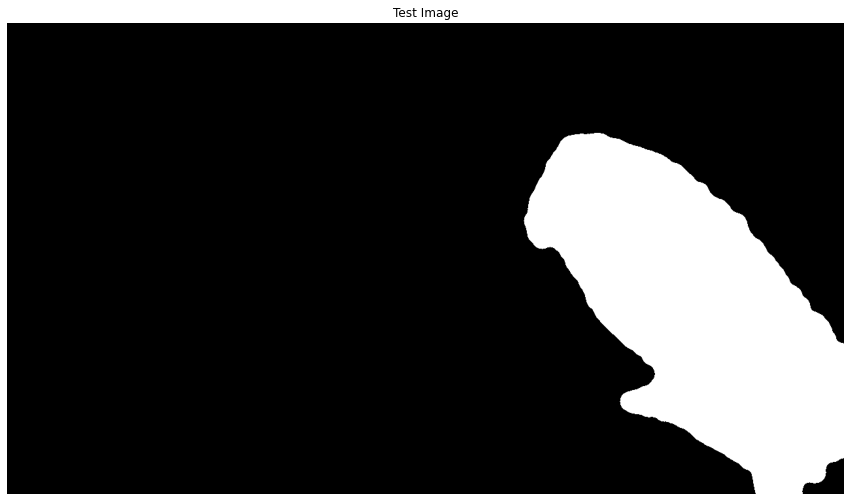

In [59]:
max_size = 0
layer = []
for i in range(1, np.max(img_seg)+1):
    max_temp = np.sum(np.where(img_seg == i, 1, 0))
    if max_temp > max_size:
        max_size = max_temp
        layer.append(i)

print(max_size)

largest_seg = np.where(img_seg == layer[-1], True, False)
plt.figure(figsize=(15,15))
plt.imshow(largest_seg, cmap='gray')
plt.title("Test Image")
plt.axis('off')
# total = skimage.segmentation.chan_vese(img_post*largest_seg, mu = 0.5) #Consider using osmehting faster from OpenCV
# plt.contour(total)

In [60]:
#------Rotation from OpenCV tutorial-----------

from __future__ import print_function
from __future__ import division
import cv2 as cv
import numpy as np
import argparse
from math import atan2, cos, sin, sqrt, pi
def drawAxis(img, p_, q_, colour, scale):
    p = list(p_)
    q = list(q_)
    
    angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
    hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
    # Here we lengthen the arrow by a factor of scale
    q[0] = p[0] - scale * hypotenuse * cos(angle)
    q[1] = p[1] - scale * hypotenuse * sin(angle)
    cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
#     # create the arrow hooks
#     p[0] = q[0] + 9 * cos(angle + pi / 4)
#     p[1] = q[1] + 9 * sin(angle + pi / 4)
#     cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
#     p[0] = q[0] + 9 * cos(angle - pi / 4)
#     p[1] = q[1] + 9 * sin(angle - pi / 4)
#     cv.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), colour, 1, cv.LINE_AA)
    

    
def getOrientation(pts, img):
    
    sz = len(pts)
    data_pts = np.empty((sz, 2), dtype=np.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigenvectors, eigenvalues = cv.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    cv.circle(img, cntr, 3, (255, 0, 255), 2)
    p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
#     drawAxis(img, cntr, p1, (255, 0, 0), 1)
#     drawAxis(img, cntr, p2, (255, 0, 0), 5)
    angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians
    
    return angle


# src = cv.imread('Images/RGB/4_Angus/4.tiff')
# # Check if image is loaded successfully
# if src is None:
#     print('Could not open or find the image: ', args.input)
#     exit(0)
# cv.imshow('src', src)
# # Convert image to grayscale
# gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
# # Convert image to binary
# _, bw = cv.threshold(gray, 0, 50, cv.THRESH_BINARY | cv.THRESH_OTSU)
# bw = np.where(largest_seg==True, 1, 0)

# contours, _ = cv.findContours(bw, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

cow_mask = np.where(largest_seg == True, 255, 0).astype('uint8')
src = cow_mask
contours, _ = cv.findContours(src, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
#cv.imshow('src', src)
for i, c in enumerate(contours):
#     Calculate the area of each contour
#     area = cv.contourArea(c)
#     # Ignore contours that are too small or too large
#     if area < 1e2 or 1e5 < area:
#         continue
#     Draw each contour only for visualisation purposes
    cv.drawContours(src, contours, i, (0, 0, 255), 2)
#     Find the orientation of each shape
    angle = getOrientation(c, src)
    angle = np.rad2deg(angle)-90
#cv.imshow('Orientation Lines', src)

# cnt = max(contours, key=cv2.contourArea)
# cv.drawContours(src, cnt, -1, (0, 0, 255), 2)
# angle = np.rad2deg(getOrientation(cnt, src))-90

print(angle)
image_center = tuple(np.array(cow_mask.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
rotated_cow = cv2.warpAffine(cow_mask, rot_mat, cow_mask.shape[1::-1], flags=cv2.INTER_LINEAR)

#cv.imshow('result', rotated_cow)

k = cv.waitKey(0)
if k == '27':
    cv2.destroyAllWindows()

# contours, _ = cv.findContours(rotated_cow, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
# max_cnt = max(contours, key=cv2.contourArea)
# angle = getOrientation(max_cnt, rotated_cow)
# print(np.rad2deg(angle))

-219.4835714022928


0 366


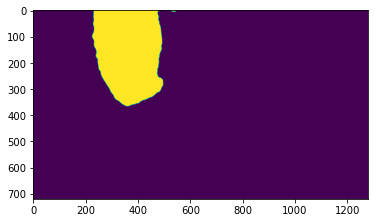

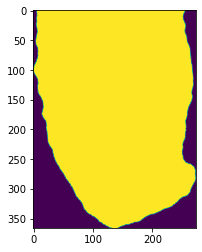

In [61]:
# cv2.drawContours(rotated_cow, max_cnt, -1, (128, 0, 0), 3)
# cv2.imshow('contours', rotated_cow)
# cv2.waitKey(0)

plt.figure()
plt.imshow(rotated_cow)

# max_y = np.max(np.where(rotated_cow == 255)[0])
# min_y = np.min(np.where(rotated_cow == 255)[0])


# max_x = np.max(np.where(rotated_cow == 255)[1])
# min_x = np.min(np.where(rotated_cow == 255)[1])

cnt, _ = cv2.findContours(rotated_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
max_cnt = max(cnt, key=cv2.contourArea)


reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

max_y_crop = np.max(reshaped_contour[::, 0])
min_y_crop = np.min(reshaped_contour[::, 0])


max_x_crop = np.max(reshaped_contour[::, 1])
min_x_crop = np.min(reshaped_contour[::, 1])

print(min_x_crop, max_x_crop)
cropped_cow = rotated_cow[min_x_crop:max_x_crop, min_y_crop:max_y_crop]

# img_seg = max(skimage.measure.label(np.where(cropped_cow != 0, 255, 0), background = 0, connectivity=2), key=np.sum())
# plt.figure()
# plt.imshow(img_seg)

plt.figure()
plt.imshow(cropped_cow)

In [62]:
# # FD = np.zeros(np.shape(rotated_cow[min_y:max_y, min_x:max_x]))
# FD = cv.ximgproc.fourierDescriptor(max_cnt)

# # print(FD.reshape(1125, 2)[0:16])
# print(np.shape(max_cnt))

In [63]:
# plt.plot(FD.reshape(1125, 2)[0:16], 'bo')

366 0 498 225


(211.6277777777778, 510.7055555555556, -18.300000000000008, 384.3000000000001)

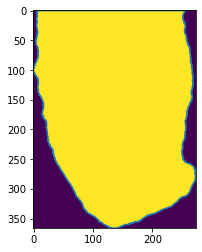

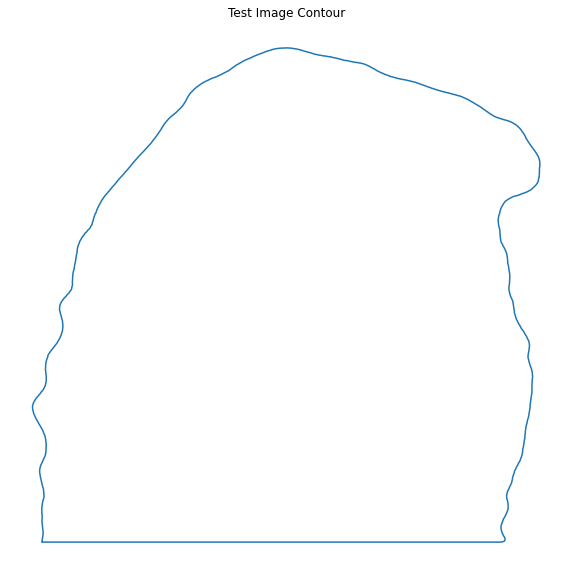

In [64]:
#------------------------Getting contour----------------------------------------------------------------
# M = skimage.measure.moments(img_cropped)
# centroid = int(M[1, 0] / M[0, 0]), int(M[0, 1] / M[0, 0])


# contours, _ = cv2.findContours(img_cropped, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# cnt, _ = cv2.findContours(cropped_cow, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# max_cnt = max(cnt, key=cv2.contourArea)


# reshaped_contour = np.asarray(max_cnt).reshape((np.shape(max_cnt)[0], 2))

# max_y = np.max(reshaped_contour[::, 0])
# min_y = np.min(reshaped_contour[::, 0])


# max_x = np.max(reshaped_contour[::, 1])
# min_x = np.min(reshaped_contour[::, 1])

print(max_x_crop, min_x_crop, max_y_crop, min_y_crop)
# print(reshaped_contour[::, 0])



plt.figure()
plt.plot(reshaped_contour[:,0]-min_y_crop, reshaped_contour[:,1]-min_x_crop)
plt.imshow(cropped_cow)



smoothed_contour = scipy.signal.savgol_filter((reshaped_contour[:,0], reshaped_contour[:,1]), 9, 1, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0).T
# print(np.shape(normalized_contour))
plt.figure(figsize=(10,10))
plt.plot(smoothed_contour[:,0], smoothed_contour[:,1])
plt.title('Test Image Contour')
plt.axis('off')

#plt.imshow(img_cropped)

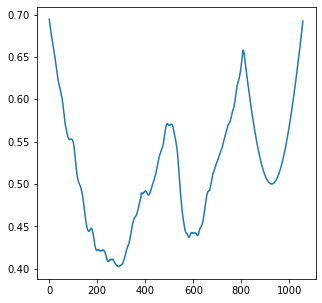

In [65]:
#---------------------------------Getting cow signature-------------------------------------
min_x = np.min(smoothed_contour[:,0])
max_x = np.max(smoothed_contour[:,0])

min_y = np.min(smoothed_contour[:,1])
max_y = np.max(smoothed_contour[:,1])

normalized_contour = np.asarray([(smoothed_contour[:,0]-min_x)/(max_x-min_x), (smoothed_contour[:,1]-min_y)/(max_y-min_y)]).T
# print(np.max(normalized_contour))


# plt.figure()
# plt.plot(normalized_contour[:,0], normalized_contour[:,1], 'bo')

        
max_loc = np.where(normalized_contour[:,1] <0.98)
# print(max_loc)
new_norm_y = normalized_contour[max_loc,1]
new_norm_x = normalized_contour[max_loc,0]

#new_norm = np.reshape([new_norm_x, new_norm_y], (np.shape(new_norm_x)[1], 2))
# print((new_norm[:,0]))


#print((new_norm_y[0:10]))
# plt.figure()
# plt.plot(new_norm_x[0:10].flatten(), new_norm_y[0:10].flatten(), 'bo')



cow_sig = np.sqrt((np.asarray(new_norm_x)-0.5)**2+(np.asarray(new_norm_y)-0.5)**2)
# print(cow_sig)
plt.figure(figsize=(5,5))
plt.plot(cow_sig[np.logical_not(np.isnan(cow_sig))])

(1057, 2)
(1102, 2)
(10, 4)


Text(0, 0.5, 'Magnitude')

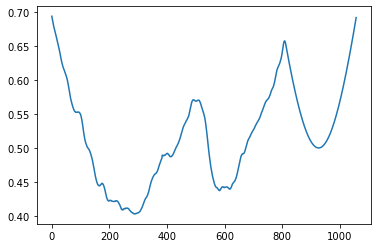

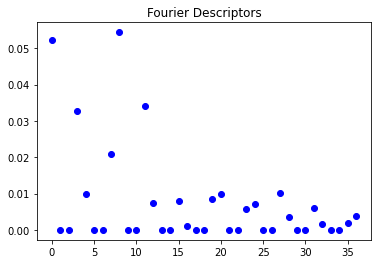

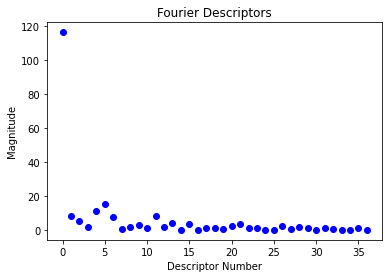

In [66]:
#------------------------Getting fourier descriptors-----------------------
# FD = cv.ximgproc.fourierDescriptor(cow_sig, FD)
# FD = np.zeros((10,10))
# FD =cv.ximgproc.fourierDescriptor(cow_sig[_, FD[_, -1[_, 10]]])

cow_sig_2d = np.zeros((len(cow_sig[0, :]), 2))
cow_sig_2d[:, 0] = np.arange(0, len(cow_sig[0, :]))
cow_sig_2d[:, 1] = cow_sig[0, :]

# cow_sig_2D = np.reshape([np.arange(0, len(cow_sig[0, :])), cow_sig[0, ::]], (len(cow_sig[0,:]), 2))

print(np.shape(cow_sig_2d))
print(np.shape(smoothed_contour))
plt.figure()
plt.plot(cow_sig_2d[:, 0], cow_sig_2d[:, 1])

FD = pyefd.elliptic_fourier_descriptors(cow_sig_2d, order=10)
plt.figure()
plt.plot(abs(FD).flatten()[3:], 'bo')
plt.title('Fourier Descriptors')

print(np.shape(FD))



FD = pyefd.elliptic_fourier_descriptors(smoothed_contour, order=10)
plt.figure()
plt.plot(abs(FD).flatten()[3:], 'bo')
plt.title('Fourier Descriptors')
plt.xlabel('Descriptor Number')
plt.ylabel('Magnitude')

C:\Users\zacha\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


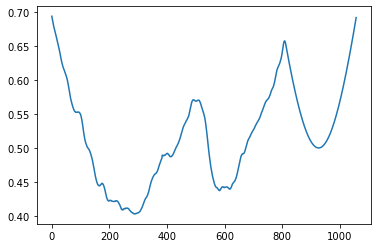

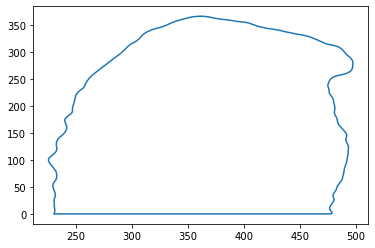

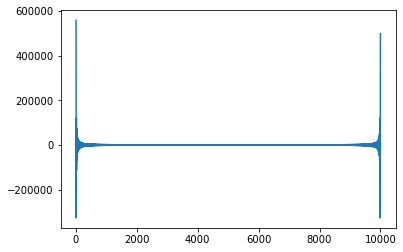

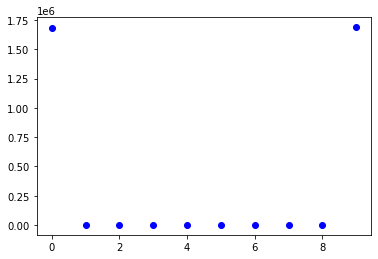

In [67]:
f = np.arange(0, 10)
#s = np.arange(0, np.shape(B)[1])
# smoothed_contour
s = np.zeros(np.shape(cow_sig_2d)[0], dtype=complex)
for k in range(np.shape(cow_sig_2d)[0]):
    s[k] = float(cow_sig_2d[k][0]) + float(cow_sig_2d[k][1])*1j
  
S = scipy.fft.fft(s, n=10000)
  # print(s[1])
  # print(type(s[1]))
for k in range(0,10):
    f[k] = np.abs(S[k*1000:(k+1)*1000].sum())
    

plt.figure()
plt.plot(cow_sig_2d[:,0], cow_sig_2d[:,1])    
    
plt.figure()
plt.plot(smoothed_contour[:,0], smoothed_contour[:,1])

plt.figure()
plt.plot(S)


plt.figure()
plt.plot(f, 'bo')

In [68]:
#-------Anatomical Landmarks---------
#-------Rotate Source Image----------

depth = imageio.imread(img_names[img_num])
rotated_depth = cv2.warpAffine(depth, rot_mat, depth.shape[1::-1], flags=cv2.INTER_LINEAR)
cropped_depth = rotated_depth[int(min_x_crop):int(max_x_crop), int(min_y_crop):int(max_y_crop)]

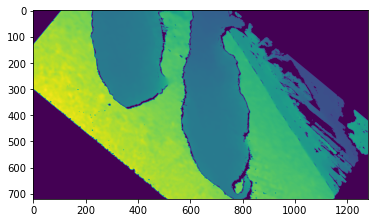

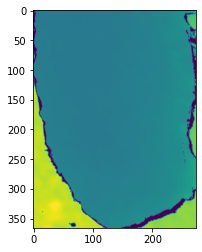

In [69]:
plt.figure()
plt.imshow(rotated_depth)

plt.figure()
plt.imshow(cropped_depth)

<class 'numpy.uint16'>


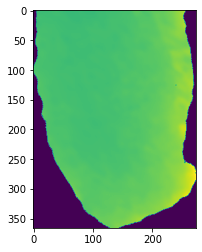

In [70]:
masked_depth = (np.where(cropped_cow!=0, 1, 0)*cropped_depth).astype('uint16')

plt.imshow(masked_depth)
print(type(masked_depth[0,0]))
length_depth, width_depth = np.shape(masked_depth)

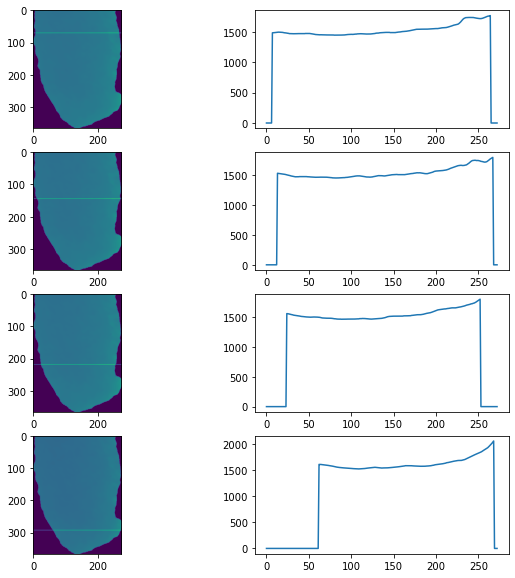

In [71]:
slice_vec = [int(length_depth/5), int(2*length_depth/5), int(3*length_depth/5), int(4*length_depth/5), length_depth]
j = 0
plt.figure(figsize=(10,10))
for i in range(1,9, 2):
    plt.subplot(4, 2, i)
    plt.imshow(masked_depth, cmap='gray')
    masked_line = np.zeros(np.shape(masked_depth))
    masked_line[slice_vec[j], 0:width_depth] = np.max(masked_depth)
    plt.imshow(masked_line+masked_depth)
    
    
    plt.subplot(4, 2, i+1)
    plt.plot(masked_depth[slice_vec[j], 0:width_depth])
    j+=1



#masked_depth_copy = masked_depth.copy()
# cv.line(masked_depth_copy, (0,width_depth), (y_coord, y_coord), (255, 0, 0), 1, cv.LINE_AA)

# cv.imshow('Path Shown', masked_depth_copy)

# k = cv.waitKey(0)
# if k == '27':
#     cv2.destroyAllWindows()

In [72]:
def threshold_percentile(img, selem, mask, p):
    img_output = np.zeros(np.shape(img))
    half_sel = np.shape(selem)[0]/2
    img_padded = np.pad(img, (half_sel, half_sel), 'constant', constant_values=(0, 0))
    for i in range(half_sel, np.shape(img)[0]):
        for j in range(half_sel, np.shape(img)[1]):
            if img_padded[i-half_sel:i+half_sel, j-half_sel:j+half_sel] < np.mean(img_padded[i-half_sel:i+half_sel, j-half_sel:j+half_sel])*p:
                img_output = 255
    

In [73]:
# selem_size = int(np.shape(cropped_cow)[0]/10)
# selem = skimage.morphology.square(50, dtype='uint8')
# plt.figure()
# plt.imshow(skimage.filters.rank.threshold_percentile(cropped_depth, selem, out=None, mask=cropped_cow, p0 =0.1))